## 진행상황

- 중성색에 대한 알고리즘은 아직 구현하지 아니함.
- KOTE 감정범주화에 대응하는 새로운 색상값을 라벨링하는 것으로 연구 방향을 정함.
- 106개의 IRI 이미지 형용사는 아직 정리하지 아니함
- Blossom 프롬프트 엔지니어링 해야함. inpu text에 대한 일관성 부족

## 1. color mapping
#### context engineering 전, dummy를 가지고 색 선정 함수를 정의하고자함.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random
import colorsys

- KOTE 44가지 감정의 긍/부정/중립 기준 적용

In [20]:
positive_emotions = ['감동/감탄', '고마움', '기대감', '기쁨', '뿌듯함',
'신기함/관심', '아껴주는', '안심/신뢰', '존경', '즐거움/신남', '편안/쾌적', '행복', '환영/호의',
'흐뭇함(귀여움/예쁨)',
]
negative_emotions = ['경악', '공포/무서움', '귀찮음', '당황/난처', '부끄러움', '부담/안_내킴', '불쌍함/연민', '불안/걱정', 
                     '불평/불만', '슬픔', '서러움', '안타까움/실망', '어이없음', '역겨움/징그러움', '의심/불신', '짜증', 
                     '재미없음', '절망', '죄책감', '증오/혐오', '지긋지긋', '패배/자기혐오', '한심함', '화남/분노', '힘듦/지침', '분노']
neutral_emotions = ['깨달음', '놀람', '비장함', '우쭐댐/무시함']

no_emotion = ['없음']

In [21]:
result_emotions_contrast = {'불쌍함/연민': 0.44,
'불안/걱정': 0.56,
'서러움': 0.51,
'슬픔': 0.7,
'아껴주는' : 0.47,
'안타까움/실망': 0.31,
'없음': 0.8,
'기쁨':0.6
}

result_emotions_similar = {'불쌍함/연민': 0.44,
'불안/걱정': 0.56,
'서러움': 0.51,
'슬픔': 0.7,
'아껴주는' : 0.47,
'안타까움/실망': 0.31,
'없음': 0.8,
'죄책감':0.6
}

result_emotions_similaremotion_contrastcolor = {'불쌍함/연민': 0.44,
'불안/걱정': 0.56,
'서러움': 0.51,
'슬픔': 0.7,
'아껴주는' : 0.47,
'안타까움/실망': 0.31,
'없음': 0.8,
'분노':0.6
}

result_IRI = '사랑스러운'

### KCoED 데이터셋 & IRI 데이터셋 가져오기

In [22]:
# CSV 파일 경로
file_path = "../data/korean emtion-color dataset 2.0 - SUM.csv"
# 파일 읽기 (처음엔 컬럼명을 무시하고 불러오기)
df_raw = pd.read_csv(file_path, header=None)

# 첫 번째 행을 컬럼명으로 지정
df_raw.columns = df_raw.iloc[1]
df = df_raw[2:]  # 첫 행은 이제 컬럼으로 사용했으니 제외

# CSV 파일 경로
file_path_IRI = "../data/임이로_학위논문_korean emtion-color dataset 2.0 - IRI-형용사스케일.csv"
# 파일 읽기 (처음엔 컬럼명을 무시하고 불러오기)
df_raw_IRI = pd.read_csv(file_path_IRI, header=None)

# 첫 번째 행을 컬럼명으로 지정
df_raw_IRI.columns = df_raw_IRI.iloc[1]
df_IRI = df_raw_IRI[2:]  # 첫 행은 이제 컬럼으로 사용했으니 제외

# CSV 파일 경로
file_path_IRI_colors = "../data/임이로_학위논문_korean emtion-color dataset 2.0 - IRI-배색스케일.csv"
# 파일 읽기 (처음엔 컬럼명을 무시하고 불러오기)
df_raw_IRI_colors = pd.read_csv(file_path_IRI_colors, header=None)

# 첫 번째 행을 컬럼명으로 지정
df_raw_IRI_colors.columns = df_raw_IRI_colors.iloc[1]
df_IRI_colors = df_raw_IRI_colors[2:]  # 첫 행은 이제 컬럼으로 사용했으니 제외

# ----------------------------------------
# 색상약호가 'White' 또는 'Black'인 행 제거
# ----------------------------------------

# '색상약호' 컬럼에 NaN이 있을 수 있으므로 fillna 처리
df_IRI_colors = df_IRI_colors[~df_IRI_colors['색상약호'].fillna('').isin(['White', 'Black'])]

In [23]:
# 필요한 열만 추출 ('형용사군', '형용사id', '형용사')
adjective_df = df_IRI[['형용사군', '형용사id', '형용사']].dropna()

# 형용사id를 숫자로 정리 (필요한 경우)
adjective_df['형용사id'] = adjective_df['형용사id'].astype(int)

# 형용사군별로 그룹화하여 리스트로 변환
grouped_adjectives = (
    adjective_df.groupby('형용사군')
    .apply(lambda g: list(g['형용사']))
    .to_dict()
)

/tmp/ipykernel_2401/2318276721.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: list(g['형용사']))


### 주감정/보조감정에 대해 KCoED데이터셋에서 주색, 보조색을 선정

In [24]:
# 감정 출력 값 전처리 : 없음을 제거, 감정 범주화에 해당하지 않는 감정 제거 ex) 한심함
def filter_emotions(result_emotions, result_IRI):
    # Filter out the '없음' key
    filtered_emotions = {key: value for key, value in result_emotions.items() if key != '없음'}
    
    # Sort emotions by their values in descending order
    sorted_emotions = sorted(filtered_emotions.items(), key=lambda item: item[1], reverse=True)
    
    # Extract the keys of the top two emotions
    top_two_emotions = [sorted_emotions[0][0], sorted_emotions[1][0], result_IRI] if len(sorted_emotions) >= 2 else []
    
    return top_two_emotions

In [25]:
# Example usage
## 주-보조 감정은 감정 분류 모델(KPoEM)에서, 형용사는 LLM모델이 반환.
top_emotions_contrast = filter_emotions(result_emotions_contrast, result_IRI)
top_emotions_similar = filter_emotions(result_emotions_similar, result_IRI)
top_emotions_similaremotion_contrastcolor = filter_emotions(result_emotions_similaremotion_contrastcolor, result_IRI)
print(top_emotions_contrast, top_emotions_similar, top_emotions_similaremotion_contrastcolor)  # Output: ['슬픔', '기쁨']

['슬픔', '기쁨', '사랑스러운'] ['슬픔', '죄책감', '사랑스러운'] ['슬픔', '분노', '사랑스러운']


In [26]:
# Function to categorize the emotion
def categorize_emotion(primary_emotion, secondary_emotion):
    # 감정 사전 정의 (예시, 필요에 따라 확장 가능)

    # 내부 분류 함수
    def classify(emotion):
        if emotion in positive_emotions:
            return "positive"
        elif emotion in negative_emotions:
            return "negative"
        elif emotion in neutral_emotions:
            return "neutral" # 아직 처리 안함.
        else:
            return "no_emotion" #아직 처리 안함.
    
    def handle_neutral_case(primary_emotion, secondary_emotion):
        # 감정이 'neutral'인 경우는 별도의 로직으로 처리
        if primary_emotion == "neutral" or secondary_emotion == "neutral":
            return "배색3"

    # 각각 분류
    primary_category = classify(primary_emotion)
    secondary_category = classify(secondary_emotion)
    
    # 'neutral'이 포함된 경우는 별도 함수로 처리
    if "neutral" in [primary_category, secondary_category] :
        print(f"Primary: {primary_category}, Secondary: {secondary_category}")
        return handle_neutral_case(primary_category, secondary_category)
    
    # 조건 비교 후 mode 반환
    if primary_category == secondary_category in ["positive", "negative"]:
        mode1 = "유사색상"
        print(f"Primary: {primary_category}, Secondary: {secondary_category}, Mode : {mode1}")
        return "유사색상"
    else:
        mode1 = "유사색상"
        print(f"Primary: {primary_category}, Secondary: {secondary_category}, Mode : {mode1}")
        return "대비색상"



In [27]:
def get_color(emotion, df):
    filtered = df[(df['감정 어휘'] == emotion) & (df['평가 순위'] == '1')]
    filtered_df_array = filtered.to_dict(orient='records')

    # (예외처리) 무작위로 하나 선택
    if filtered_df_array:
        return random.choice(filtered_df_array)
    else:
        return None

In [28]:
def get_color_info(top_ranked_value):
    munsell_colors = ['R', 'YR', 'Y', 'GY', 'G', 'BG', 'B', 'PB', 'P', 'RP']
    total = len(munsell_colors)

    if top_ranked_value['색상약호'] not in munsell_colors:
        return "unknown_color"
    # 색상약호의 인덱스 찾기
    idx = munsell_colors.index(top_ranked_value['색상약호'])

    # 유사색상군
    similar_1_idx = [(idx - 1) % total, (idx + 1) % total]
    similar_2_idx = [(idx - 2) % total, (idx + 2) % total]

    # 대비색상군
    contrast_2_idx = [(idx - 3) % total, (idx + 3) % total]
    contrast_1_idx = [(idx - 4) % total, (idx + 4) % total]
    contrast_idx = [(idx - 5) % total]  # 보색 (정반대 5칸 거리)

    # 변환
    similar_colors_1 = [munsell_colors[i] for i in similar_1_idx]
    similar_colors_2 = [munsell_colors[i] for i in similar_2_idx]
    contrast_colors_2 = [munsell_colors[i] for i in contrast_2_idx]
    contrast_colors_1 = [munsell_colors[i] for i in contrast_1_idx]
    contrast_color = [munsell_colors[i] for i in contrast_idx]

    return {
        "center_color": top_ranked_value,
        "similar_colors_1": similar_colors_1,
        "similar_colors_2": similar_colors_2,
        "contrast_colors_1": contrast_colors_1,
        "contrast_colors_2": contrast_colors_2,
        "contrast_color": contrast_color  # 보색
    }
        

In [29]:
def similar_mapping(primary_color_info, secondary_emotion, df):
    # secondary_ranked_value = df[df['감정 어휘'] == secondary_emotion].sort_values(by='평가 순위').iloc[0].to_dict()
    secondary_ranked_df = df[df['감정 어휘'] == secondary_emotion]
    
    similar_matches_1 = []
    similar_matches_2 = []
    similar_match_exact = []

            
    # similar_colors_1 체크
    for similar_color in primary_color_info['similar_colors_1']:
        matched = secondary_ranked_df[secondary_ranked_df['색상약호'] == similar_color]
        if not matched.empty:
            similar_matches_1.append(matched)

    # similar_colors_2 체크
    for similar_color in primary_color_info['similar_colors_2']:
        matched = secondary_ranked_df[secondary_ranked_df['색상약호'] == similar_color]
        if not matched.empty:
            similar_matches_2.append(matched)
            
    # same_color (동일색) 체크
    same_color = primary_color_info['center_color']  # 단일 값 리스트 #주색은 미리 딕셔너리로 보관됨. 그대로 가져옴.
    matched_exact = secondary_ranked_df[secondary_ranked_df['색상약호'] == same_color]
    if not matched_exact.empty:
        similar_match_exact.append(matched_exact)
    
    # 유사색상군1과 유사색상군2 중 하나라도 일치하는 경우.
    if similar_matches_1 or similar_matches_2: 
        if similar_matches_1: # 대비색상군1을 우선 선정.
            similar_matches_1_df = pd.concat(similar_matches_1).to_dict(orient='records')
            # print(similar_matches_1_df)
            return {"primary_color" : primary_color_info['center_color'],
                    "secondary_color" : min(similar_matches_1_df, key=lambda x: x['평가 순위'])}
        else: #대비색상군1이 없고, 대비색상군2가 있는 경우
            similar_matches_2_df = pd.concat(similar_matches_2).to_dict(orient='records')
            # print(similar_matches_2_df)
            return {"primary_color" : primary_color_info['center_color'],
                    "secondary_color" :min(similar_matches_2_df, key=lambda x: x['평가 순위'])}
            
    # 동일색이 있는경우
    if similar_match_exact:
        similar_dicts = similar_match_exact[0].to_dict(orient='records')
        return {"primary_color" : primary_color_info['center_color'],
                "secondary_color" : min(similar_dicts, key=lambda x: x['평가 순위'])} # '평가 순위'가 가장 높은 값 (숫자가 클수록 높은 순위라면 ↓)
        
    # 유사색상이 없는 경우
    pure_secondary_colors = get_color(secondary_emotion, df)
    return {"primary_color" : primary_color_info['center_color'], "secondary_color" :pure_secondary_colors}

In [30]:
def contrast_mapping(primary_color_info, secondary_emotion, df):
    secondary_ranked_df = df[df['감정 어휘'] == secondary_emotion]
        
    contrast_matches_1 = []
    contrast_matches_2 = []
    contrast_match_exact = []

            
    # contrast_colors_1 체크
    for contrast_color in primary_color_info['contrast_colors_1']:
        matched = secondary_ranked_df[secondary_ranked_df['색상약호'] == contrast_color]
        if not matched.empty:
            contrast_matches_1.append(matched)

    # contrast_colors_2 체크
    for contrast_color in primary_color_info['contrast_colors_2']:
        matched = secondary_ranked_df[secondary_ranked_df['색상약호'] == contrast_color]
        if not matched.empty:
            contrast_matches_2.append(matched)
            
    # contrast_color (보색) 체크
    contrast_color = primary_color_info['contrast_color'][0]  # 단일 값 리스트
    matched_exact = secondary_ranked_df[secondary_ranked_df['색상약호'] == contrast_color]
    if not matched_exact.empty:
        contrast_match_exact.append(matched_exact)
    
    #보색이 정확히 일치하는 경우
    if contrast_match_exact:
        contrast_dicts = contrast_match_exact[0].to_dict(orient='records')
        return {"primary_color" : primary_color_info['center_color'],
                "secondary_color" : min(contrast_dicts, key=lambda x: x['평가 순위'])} # '평가 순위'가 가장 높은 값 (숫자가 클수록 높은 순위라면 ↓)
    
    # 대비색상군1과 대비색상군2 중 하나라도 일치하는 경우.
    if contrast_matches_1 or contrast_matches_2: 
        if contrast_matches_1: # 대비색상군1을 우선 선정.
            contrast_matches_1_df = pd.concat(contrast_matches_1).to_dict(orient='records')
            # print(contrast_matches_1_df)
            return {"primary_color" : primary_color_info['center_color'],
                    "secondary_color" : min(contrast_matches_1_df, key=lambda x: x['평가 순위'])}
        else: #대비색상군1이 없고, 대비색상군2가 있는 경우
            contrast_matches_2_df = pd.concat(contrast_matches_2).to_dict(orient='records')
            # print(contrast_matches_2_df)
            return {"primary_color" : primary_color_info['center_color'],
                    "secondary_color" :min(contrast_matches_2_df, key=lambda x: x['평가 순위'])}
    # 대비색상이 없는 경우
    pure_secondary_colors = get_color(secondary_emotion, df)
    return {"primary_color" : primary_color_info['center_color'], "secondary_color" :pure_secondary_colors}  # '평가 순위'가 가장 높은 값 (숫자가 클수록 높은 순위라면 ↓)

In [31]:
def get_sencondary_color(primary_color_info, secondary_emotion, mode_colors, df):
    # 유사색상 모드일 때
    if mode_colors == "유사색상":
        return similar_mapping(primary_color_info, secondary_emotion, df)
    # 대비색상 모드일 때
    elif mode_colors == "대비색상": 
        return contrast_mapping(primary_color_info, secondary_emotion, df)
        
    # 예외처리 : 대비색상, 대비색상군1, 대비색상군2가 전부 없는 경우

In [32]:
# def define_colors(primary_emotion, secondary_emotion, df):
#     mode_colors = categorize_emotion(primary_emotion, secondary_emotion)
#     # top_ranked_value = df[df['감정 어휘'] == primary_emotion].sort_values(by='평가 순위').iloc[0].to_dict()
#     # top_ranked_value = df[df['감정 어휘'] == primary_emotion].sort_values(by='평가 순위')
#     # filtered = df[(df['감정 어휘'] == primary_emotion) & (df['평가 순위'] == 1)]
    
#     primary_color_data = get_color(primary_emotion, df) # 무작위로 하나 선택
#     primary_color_info_test= get_primary_color(primary_color_data)
#     return get_sencondary_color(primary_color_info_test, secondary_emotion, mode_colors, df)
    

In [33]:
# colors_similar = define_colors(top_emotions_similar[0],top_emotions_similar[1], df) # 주감정과 보조감정, KCoED 데이터셋
# colors_similar

In [34]:
# colors_similar_contrast = define_colors(top_emotions_similaremotion_contrastcolor[0],top_emotions_similaremotion_contrastcolor[1], df) # 주감정과 보조감정, KCoED 데이터셋
# colors_similar_contrast

### 주색/보조색을 가지고 컬러 변환

In [35]:
def rgb_to_hsb(rgb_dict):
    # 문자열 RGB 값을 정수로 변환
    r = int(rgb_dict['R']) / 255.0
    g = int(rgb_dict['G']) / 255.0
    b = int(rgb_dict['B']) / 255.0

    # RGB → HSB (HSV)
    h, s, v = colorsys.rgb_to_hsv(r, g, b)

    # HSB 값 반환 (0~360, 0~100, 0~100)
    return {
        'H': round(h * 360), #반올림
        'S': round(s * 100),
        'B': round(v * 100),
        'color info' : rgb_dict
    }

In [36]:
# processed_primary_color1 = rgb_to_hsb(colors_similar['primary_color'])
# processed_secondary_color1 = rgb_to_hsb(colors_similar['secondary_color'])

In [37]:
# processed_primary_color2 = rgb_to_hsb(colors_contrast['primary_color'])
# processed_secondary_color2 = rgb_to_hsb(colors_contrast['secondary_color'])

In [38]:
# processed_primary_color3 = rgb_to_hsb(colors_similar_contrast['primary_color'])
# processed_secondary_color3 = rgb_to_hsb(colors_similar_contrast['secondary_color'])

#### 형용사 정리 (버그수정)

#### 추출한 감정형용사의 형용사군 검색

In [39]:
def find_adjective_group(adjective, grouped_dict):
    """
    주어진 형용사가 속한 형용사군(key)을 반환.
    """
    for group, adjectives in grouped_dict.items():
        if adjective in adjectives:
            return group
    return None  # 못 찾았을 경우

In [40]:
group_name = find_adjective_group(result_IRI, grouped_adjectives)

if group_name:
    print(f"형용사 '{result_IRI}'는 '{group_name}' 형용사군에 속합니다.")
else:
    print(f"형용사 '{result_IRI}'는 어떤 형용사군에도 속하지 않습니다.")

형용사 '사랑스러운'는 '귀여운' 형용사군에 속합니다.


In [41]:
IRI_colors_df = df_IRI_colors[df_IRI_colors['형용사군'] == group_name]
# '배색그룹id' 컬럼에서 고유값만 추출
palette_ids = IRI_colors_df['배색그룹id'].dropna().unique()

# 랜덤 선택
if len(palette_ids) > 0:
    chosen_palette_id = random.choice(palette_ids)
    print(f"선택된 배색그룹id: {chosen_palette_id}")
else:
    chosen_palette_id = None
    print("배색그룹id가 존재하지 않습니다.")
    
# chosen_palette_id에 해당하는 행만 추출
palette_df = IRI_colors_df[IRI_colors_df['배색그룹id'] == chosen_palette_id]

선택된 배색그룹id: 3


In [42]:
def choose_color_pair(palette_df):
    # 사용할 쌍 정의 (우선순위 순서)
    priority_pairs = [(1, 2), (2, 3), (2, 1), (3, 2)]
    fallback_pairs = [(1, 3), (3, 1)]

    # 현재 데이터프레임에 존재하는 단일색상 id 추출
    available_ids = set(palette_df['단일색상 id'].dropna().astype(int).unique())

    # 가능한 쌍 필터링
    valid_priority_pairs = [pair for pair in priority_pairs if pair[0] in available_ids and pair[1] in available_ids]
    valid_fallback_pairs = [pair for pair in fallback_pairs if pair[0] in available_ids and pair[1] in available_ids]

    # 랜덤 선택
    if valid_priority_pairs:
        return random.choice(valid_priority_pairs)
    elif valid_fallback_pairs:
        return random.choice(valid_fallback_pairs)
    else:
        return None

In [43]:
def get_palette_dicts(palette_df):
    """
    palette_result 튜플 (id1, id2)에 대해 해당하는 단일색상id 행을
    각각 dictionary로 반환
    """
    palette_result = choose_color_pair(palette_df)
    id1, id2 = palette_result

    # '단일색상 id' 컬럼이 float일 가능성 있으므로 int로 캐스팅
    df_cast = palette_df.copy()
    df_cast['단일색상 id'] = df_cast['단일색상 id'].astype(int)

    # 각 색상 id에 대응하는 행 추출 후 dict 변환
    primary_row = df_cast[df_cast['단일색상 id'] == id1].iloc[0].to_dict()
    secondary_row = df_cast[df_cast['단일색상 id'] == id2].iloc[0].to_dict()

    return {'primary_palette' : primary_row, 'secondary_palette' : secondary_row}

In [44]:
palette_result = get_palette_dicts(palette_df)

In [45]:
def update_saturation_brightness(processed_primary_color, processed_secondary_color, palette_result):
    """
    processed_primary_color와 processed_secondary_color의 S, B 값을
    palette_result의 S, B 값으로 업데이트합니다.
    """
    processed_primary_color['S'] = palette_result['primary_palette']['Saturation']
    processed_primary_color['B'] = palette_result['primary_palette']['Brightness']
    processed_secondary_color['S'] = palette_result['secondary_palette']['Saturation']
    processed_secondary_color['B'] = palette_result['secondary_palette']['Brightness']

    return {'updated_primary_color': processed_primary_color,
            'updated_secondary_color': processed_secondary_color
            }

In [46]:
# updated_colors1 = update_saturation_brightness(processed_primary_color1, processed_secondary_color1, palette_result)
# updated_colors2 = update_saturation_brightness(processed_primary_color2, processed_secondary_color2, palette_result)
# updated_colors3 = update_saturation_brightness(processed_primary_color3, processed_secondary_color3, palette_result)

#### 감정 어휘 정리 (진행예정)

In [150]:
def filter_emotion_text(emotion_name):
    if emotion_name == '기대감' :
        return '기대하다'
    else : 
        return emotion_name

In [151]:

def define_colors(result_emotions, result_IRI, df, IRI_colors_df):
    top_two_emotions = filter_emotions(result_emotions, result_IRI)
    mode1 = categorize_emotion(top_two_emotions[0],top_two_emotions[1])
    filtered_top_two_emotion = filter_emotion_text(top_two_emotions[0]) # 임시적용
    primary_color = get_color(filtered_top_two_emotion, df) # 무작위로 하나 선택
    primary_color_info_data = get_color_info(primary_color)
    
    selected_colors = get_sencondary_color(primary_color_info_data, top_two_emotions[1], mode1, df)
    processed_primary_color = rgb_to_hsb(selected_colors['primary_color'])
    processed_secondary_color = rgb_to_hsb(selected_colors['secondary_color'])
    
    group_name = find_adjective_group(result_IRI, grouped_adjectives)
    if group_name:
        print(f"형용사 '{result_IRI}'는 '{group_name}' 형용사군에 속합니다.")
    else:
        print(f"형용사 '{result_IRI}'는 어떤 형용사군에도 속하지 않습니다.")
        
    IRI_colors_df = df_IRI_colors[df_IRI_colors['형용사군'] == group_name]
    # '배색그룹id' 컬럼에서 고유값만 추출
    palette_ids = IRI_colors_df['배색그룹id'].dropna().unique()

    # 랜덤 선택
    if len(palette_ids) > 0:
        chosen_palette_id = random.choice(palette_ids)
        print(f"선택된 배색그룹id: {chosen_palette_id}")
    else:
        chosen_palette_id = None
        print("배색그룹id가 존재하지 않습니다.")
    
    # chosen_palette_id에 해당하는 행만 추출
    palette_df = IRI_colors_df[IRI_colors_df['배색그룹id'] == chosen_palette_id]    
    palette_result = get_palette_dicts(palette_df)
    updated_colors = update_saturation_brightness(processed_primary_color, processed_secondary_color, palette_result)
    updated_colors['primary_emotion'] = top_two_emotions[0]
    updated_colors['secondary_emotion'] = top_two_emotions[1]
    return updated_colors

In [152]:
colors_contrast = define_colors(result_emotions_contrast, result_IRI, df, IRI_colors_df) # 주감정과 보조감정, KCoED 데이터셋
colors_contrast


Primary: negative, Secondary: positive, Mode : 유사색상
형용사 '사랑스러운'는 '귀여운' 형용사군에 속합니다.
선택된 배색그룹id: 2


{'updated_primary_color': {'H': 214,
  'S': '58',
  'B': '96',
  'color info': {'감정id': '24',
   '감정 어휘': '슬픔',
   '평가 순위': '1',
   'R': '76',
   'G': '87',
   'B': '101',
   '샘플': nan,
   '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.',
   '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268753',
   '색상': '남색',
   '색상약호': 'PB',
   '색상 온도': 'Cold',
   nan: nan}},
 'updated_secondary_color': {'H': 51,
  'S': '49',
  'B': '98',
  'color info': {'감정id': '17',
   '감정 어휘': '기쁨',
   '평가 순위': '1',
   'R': '238',
   'G': '201',
   'B': '0',
   '샘플': nan,
   '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.',
   '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268700',
   '색상': '노랑',
   '색상약호': 'Y',
   '색상 온도': 'Warm',
   nan: nan}},
 'primary_emotion': '슬픔',
 'secondary_emotion': '기쁨'}

In [49]:
def hsb_to_rgb_tuple(hsb):
    h = int(hsb['H']) / 360
    s = int(hsb['S']) / 100
    v = int(hsb['B']) / 100
    r, g, b = colorsys.hsv_to_rgb(h, s, v)
    return (r, g, b)  # matplotlib uses 0-1 float RGB

In [50]:
def emotion_to_colors(top_emotions, color_results):
    plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False

    # RGB 변환
    rgb1 = hsb_to_rgb_tuple(color_results['updated_primary_color'])
    rgb2 = hsb_to_rgb_tuple(color_results['updated_secondary_color'])

    # Figure + GridSpec (7:3 비율)
    fig = plt.figure(figsize=(7, 2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[7, 3])

    # Primary Color 영역 (7)
    ax1 = fig.add_subplot(gs[0])
    ax1.imshow([[rgb1]], aspect='auto')
    ax1.set_title("Primary Color", fontsize=10)
    ax1.axis('off')

    # Secondary Color 영역 (3)
    ax2 = fig.add_subplot(gs[1])
    ax2.imshow([[rgb2]], aspect='auto')
    ax2.set_title("Secondary Color", fontsize=10)
    ax2.axis('off')

    # 전체 제목
    # plt.suptitle(f"{top_emotions[2]}, {top_emotions[0]}과(와) {top_emotions[1]}", fontsize=14)
    # 그래프 아래 중앙에 제목 넣기
    fig.text(
        0.5, -0.05,  # x, y (0~1 기준, 아래로 -0.05)
        f"{top_emotions[2]}, {top_emotions[0]}과(와) {top_emotions[1]}",
        ha='center', va='top',
        fontsize=14
)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
    print(top_emotions, color_results)

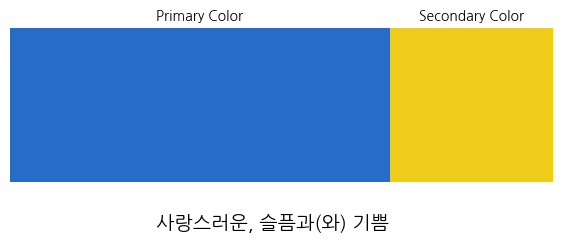

['슬픔', '기쁨', '사랑스러운'] {'updated_primary_color': {'H': 214, 'S': '80', 'B': '78', 'color info': {'감정id': '24', '감정 어휘': '슬픔', '평가 순위': '1', 'R': '76', 'G': '87', 'B': '101', '샘플': nan, '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.', '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268753', '색상': '남색', '색상약호': 'PB', '색상 온도': 'Cold', nan: nan}}, 'updated_secondary_color': {'H': 51, 'S': '89', 'B': '93', 'color info': {'감정id': '17', '감정 어휘': '기쁨', '평가 순위': '1', 'R': '238', 'G': '201', 'B': '0', '샘플': nan, '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.', '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268700', '색상': '노랑', '색상약호': 'Y', '색상 온도': 'Warm', nan: nan}}}


In [51]:
# emotion_to_colors(top_emotions_similar, updated_colors1)
# emotion_to_colors(top_emotions_contrast, updated_colors2)
# emotion_to_colors(top_emotions_similaremotion_contrastcolor, updated_colors3)
emotion_to_colors(top_emotions_contrast, colors_contrast)

## KPoEM 감정분류 모델 로드

In [52]:
!pip install langchain langchain-community langchain-core
!pip install faiss-cpu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/bitsandbytes-0.45.4.dev0-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading eg

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/bitsandbytes-0.45.4.dev0-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading eg

In [53]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
import os
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import pytorch_lightning as pl
import torch
torch.set_float32_matmul_precision('medium')
import torch.nn as nn
from transformers import ElectraModel, AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split

In [54]:
###########################
# 토크나이저 로드
###########################
MODEL_NAME = "beomi/KcELECTRA-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [55]:
THRESHOLD = 0.3

In [56]:
# 2.1. 공통 전처리 함수 및 라벨 정의
LABELS = ['불평/불만', '환영/호의', '감동/감탄', '지긋지긋', '고마움', '슬픔', '화남/분노', '존경', '기대감', '우쭐댐/무시함', '안타까움/실망', '비장함', '의심/불신', '뿌듯함', '편안/쾌적', '신기함/관심', '아껴주는', '부끄러움', '공포/무서움', '절망', '한심함', '역겨움/징그러움', '짜증', '어이없음', '없음', '패배/자기혐오', '귀찮음', '힘듦/지침', '즐거움/신남', '깨달음', '죄책감', '증오/혐오', '흐뭇함(귀여움/예쁨)', '당황/난처', '경악', '부담/안_내킴', '서러움', '재미없음', '불쌍함/연민', '놀람', '행복', '불안/걱정', '기쁨', '안심/신뢰']

In [57]:
# 3.4. Pytorch Lightning 모델(BaseTagger) 정의
class BaseTagger(pl.LightningModule):
    def __init__(self, model_name=MODEL_NAME, lr=2e-5, weight_decay=0.01,
                 n_training_steps=None, n_warmup_steps=None, dropout_rate=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.electra = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Sequential(
            nn.Dropout(p=self.hparams.dropout_rate),
            nn.Linear(self.electra.config.hidden_size, len(LABELS))
        )
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.electra(input_ids, attention_mask=attention_mask)
        logits = self.classifier(output.last_hidden_state[:, 0, :])
        probs = torch.sigmoid(logits)

        if labels is not None:
            loss = self.criterion(probs, labels)
            return loss, probs
        return None, probs

    def training_step(self, batch, batch_idx):
        loss, _ = self(**batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, _ = self(**batch)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.hparams.n_warmup_steps,
            num_training_steps=self.hparams.n_training_steps
        )
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "step"}}

In [58]:
best_ckpt_path_poetry = '../model/best_model_B_minmax_0.2.ckpt' # Colab 경로에 맞게 수정
print("Best checkpoint path:", best_ckpt_path_poetry)

Best checkpoint path: ../model/best_model_B_minmax_0.2.ckpt


In [59]:
best_model_poetry = BaseTagger.load_from_checkpoint(best_ckpt_path_poetry)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model_poetry.to(device)
best_model_poetry.eval()
best_model_poetry.freeze()

In [60]:
def classify_emotion(sample_text):

    encoding = tokenizer(
        sample_text,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    with torch.no_grad():
        # 입력 텐서 또한 같은 device로 이동
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        # forward
        _, predictions = best_model_poetry(input_ids, attention_mask)  # best_model_poetry 사용

    # 추론 결과를 CPU로 가져와 numpy로 변환
    predictions = predictions.flatten().cpu().numpy()

    # 결과를 딕셔너리로 저장 (숫자값으로 변환)
    result_dict = {
        label_name: float(round(score, 3))  # np.float32 -> float 변환
        for label_name, score in zip(LABELS, predictions)
        if score > THRESHOLD
    }

    return result_dict
    # 예시 출력
    # {'불안/걱정': 0.336, '슬픔': 0.311}

In [61]:
sample_text = """
미풍이 웃는 아침을 기원하련다
""" # 송몽규 - 하늘과 더불어

##### 샘플 텍스트에 대한 감정분류

In [79]:
poem_emotions = classify_emotion(sample_text)
poem_emotions

{'환영/호의': 0.6579999923706055,
 '감동/감탄': 0.46399998664855957,
 '슬픔': 0.31700000166893005,
 '기대감': 0.9459999799728394,
 '편안/쾌적': 0.34200000762939453,
 '신기함/관심': 0.3449999988079071,
 '아껴주는': 0.753000020980835,
 '즐거움/신남': 0.5619999766349792,
 '흐뭇함(귀여움/예쁨)': 0.4729999899864197,
 '행복': 0.6830000281333923,
 '기쁨': 0.8529999852180481}

## 3. Langchain (Blossom)

In [106]:
!pip install --upgrade langchain

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/bitsandbytes-0.45.4.dev0-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.12.0.dev0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/looseversion-1.3.0-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading eg

In [108]:
from langchain_community.llms import Ollama
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
# from langchain.output_parsers import StrOutputParser
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import re

#### Blossom 로드

In [82]:
model_id = "Bllossom/llama-3.2-Korean-Bllossom-3B"

# 토크나이저 로드
tokenizer_bllossom = AutoTokenizer.from_pretrained(model_id)
tokenizer_bllossom.pad_token = tokenizer_bllossom.eos_token  # Blossom은 pad_token이 없음

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [130]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16  # 또는 "auto"
)

# 2. 텍스트 생성 파이프라인
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer_bllossom,
    temperature=0.3, #	생성의 무작위성 조절 계수
    top_p=0.9, # 누적 확률이 top_p 이하인 토큰들만 고려
    max_new_tokens=4, #한 번에 생성할 최대 토큰 수입니다. (입력 프롬프트 제외)
    repetition_penalty=1.5 # 반복되는 단어에 대한 페널티
)

# 3. LangChain용 LLM 래퍼
llm = HuggingFacePipeline(pipeline=pipe)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [122]:
# 중복 제거 후 정렬
adjectives = sorted(df_IRI['형용사'].dropna().unique())
# 배열을 콤마 구분 문자열로 변환
adjectives_str = ",".join(adjectives)

print(adjectives_str)

가벼운,가지런한,간편한,감각적인,감미로운,감성적인,강인한,강한,개성적인,거친,건실한,격식있는,견고한,고급스러운,그윽한,기능적인,기운찬,깊은,깔끔한,나이든,남성적인,넉넉한,다양한,단순한,단정한,달콤한,도시적인,돋보이는,동양적인,동적인,딱딱한,뛰어난,맑은,매끄러운,매력적인,멋진,무거운,밝은,보수적인,복잡한,부드러운,사랑스러운,상쾌한,새로운,서양적인,선명한,섬세한,성숙한,세련된,소박한,수수한,순수한,스포티한,시원한,신선한,실용적인,심플한,싱싱한,아기자기한,안정된,약한,얕은,어두운,여성적인,여유있는,연약한,오래된,와일드한,우울한,유연한,율동적인,이성적인,인공적인,자연적인,자유로운,잔잔한,장식적인,재미있는,전원적인,전통적인,젊은,정다운,정돈된,정적인,조용한,중후한,즐거운,지적인,진보적인,차가운,차분한,친근한,쾌활한,클래식한,탁한,투명한,편리한,편안한,포근한,품위있는,풍성한,하이테크한,한국적인,향기로운,혁신적인,환상적인,활동적인


#### 프롬프트 엔지니어링 (no Vectior)

In [111]:
# 3) 후처리: 화이트리스트(=adjectives) 안에서만 허용
def pick_one_adjective(raw_text: str, candidates: list[str]) -> str:
    # 공백/따옴표/기호 제거
    text = raw_text.strip()
    text = re.sub(r"[\"'«»「」\[\]\(\)<>]", "", text)
    text = re.sub(r"\s+", "", text)

    # 정확 매칭
    if text in candidates:
        return text

    # 혹시 문장으로 나왔을 때, 후보 중 포함되는 첫 단어 뽑기
    for cand in candidates:
        if cand in raw_text:
            return cand

    # 마지막 안전장치: 첫 번째 후보 반환
    return candidates[0]

In [127]:
# 8️⃣ 전체 체인
def CoReadingPoem(user_input):
    # 프롬프트 생성
    
    template = """
    ### 시스템:
    당신은 인간과 함께 '{context_snippets}' 라는 시를 읽고 있습니다.
    아래 106개의 '감정형용사' 중에서 **가장 적합한 하나만** 고르세요.

    감정형용사: {adjective}

    ### 출력 형식(아주 중요):
    - 목록에 있는 형용사 **한 단어만** 출력하세요.
    - 따옴표/기타 설명/접두사/접미사/기호 금지.
    - 예: 밝은
    """

    prompt = PromptTemplate(
        input_variables=["adjective", "context_snippets"],
        template=template.strip()
    )
    
    # print(template)
    chain = LLMChain(llm=llm, prompt=prompt)
    result = chain.run(adjective=adjectives_str, context_snippets=user_input)
    final_choice = pick_one_adjective(result, adjectives)
    # 결과 출력
    return final_choice

In [131]:
import random
import re
from langchain import PromptTemplate, LLMChain

# 후보 1개만 남기는 후처리(혹시 숫자 대신 단어가 오면 대비)
def pick_one_adjective(raw_text: str, candidates: list[str]) -> str:
    t = re.sub(r"[\"'«»「」\[\]\(\)<>]", "", raw_text).strip()
    t = re.sub(r"\s+", "", t)
    # 정확 매칭
    if t in candidates:
        return t
    # 포함 매칭
    for c in candidates:
        if c in raw_text:
            return c
    return candidates[0]

def CoReadingPoem(user_input: str) -> str:
    # 1) 매 호출마다 순서 섞기 (위치 바이어스 제거)
    shuffled = random.sample(adjectives, k=len(adjectives))

    # 2) 번호 달아서 제시 (숫자만 출력하도록 유도)
    numbered = "\n".join(f"{i+1}. {w}" for i, w in enumerate(shuffled))

    template = """
    ### 시스템
    당신은 인간과 함께 다음 시를 읽고 있습니다:
    {context_snippets}

    아래 '감정형용사' 목록 중에서 **가장 적합한 하나**를 고르세요.

    감정형용사 목록:
    {numbered_adjectives}

    ### 출력 형식(아주 중요)
    - 선택한 항목의 **번호만** 출력하세요 (예: 17)
    - 다른 말/기호/공백 금지
    """

    prompt = PromptTemplate(
        input_variables=["context_snippets", "numbered_adjectives"],
        template=template.strip()
    )
    chain = LLMChain(llm=llm, prompt=prompt)

    # 3) 생성은 짧고 보수적으로 (수다 방지)
    #    * HF 파이프라인을 썼다면 사전에 temperature/top_p/max_new_tokens를 낮춰둔 상태가 좋아요.
    raw = chain.run(
        context_snippets=user_input,
        numbered_adjectives=numbered
    )

    # 4) 숫자 파싱 -> 인덱스 매핑
    m = re.search(r"\d+", raw)
    if m:
        idx = int(m.group()) - 1
        if 0 <= idx < len(shuffled):
            return shuffled[idx]

    # 5) 비상구: 숫자 못 뽑았으면 기존 후처리로 보정
    return pick_one_adjective(raw, shuffled)


In [176]:
CoReading_Result = CoReadingPoem(sample_text)
CoReading_Result 

'유연한'

##### 시 감정에 대한 색 정보 얻기

In [177]:
poem_colors = define_colors(poem_emotions, CoReading_Result , df, IRI_colors_df)
poem_colors

Primary: positive, Secondary: positive, Mode : 유사색상
형용사 '유연한'는 '온화환' 형용사군에 속합니다.
선택된 배색그룹id: 3


{'updated_primary_color': {'H': 70,
  'S': '15',
  'B': '62',
  'color info': {'감정id': '2',
   '감정 어휘': '기대하다',
   '평가 순위': '1',
   'R': '194',
   'G': '214',
   'B': '94',
   '샘플': nan,
   '출처/참고문헌': '한국 성인의 감정 색채 반응 연구(한지운·나건, 2021)',
   '출처/참고문헌2': nan,
   '색상': '연두',
   '색상약호': 'GY',
   '색상 온도': 'Neutral',
   nan: nan}},
 'updated_secondary_color': {'H': 51,
  'S': '13',
  'B': '87',
  'color info': {'감정id': '17',
   '감정 어휘': '기쁨',
   '평가 순위': '1',
   'R': '238',
   'G': '201',
   'B': '0',
   '샘플': nan,
   '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.',
   '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268700',
   '색상': '노랑',
   '색상약호': 'Y',
   '색상 온도': 'Warm',
   nan: nan}},
 'primary_emotion': '기대감',
 'secondary_emotion': '기쁨'}

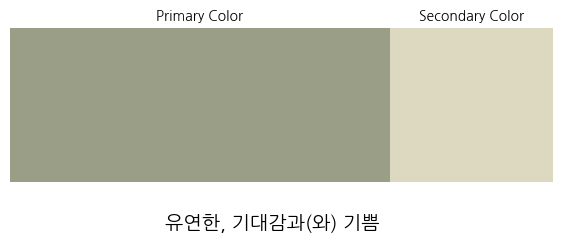

['기대감', '기쁨', '유연한'] {'updated_primary_color': {'H': 70, 'S': '15', 'B': '62', 'color info': {'감정id': '2', '감정 어휘': '기대하다', '평가 순위': '1', 'R': '194', 'G': '214', 'B': '94', '샘플': nan, '출처/참고문헌': '한국 성인의 감정 색채 반응 연구(한지운·나건, 2021)', '출처/참고문헌2': nan, '색상': '연두', '색상약호': 'GY', '색상 온도': 'Neutral', nan: nan}}, 'updated_secondary_color': {'H': 51, 'S': '13', 'B': '87', 'color info': {'감정id': '17', '감정 어휘': '기쁨', '평가 순위': '1', 'R': '238', 'G': '201', 'B': '0', '샘플': nan, '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.', '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268700', '색상': '노랑', '색상약호': 'Y', '색상 온도': 'Warm', nan: nan}}, 'primary_emotion': '기대감', 'secondary_emotion': '기쁨'}


In [178]:
emotion_to_colors([poem_colors['primary_emotion'],poem_colors['secondary_emotion'], CoReading_Result], poem_colors)